In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
import functions_hiwi as fct
import warnings
import xarray as xr
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle

In [2]:
# set ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
# set main directory
main_dir = r'C:\Users\illic\Python\data_hiwi\Emschergenossenschaft'

In [4]:
# set path to data
emscher_path = os.path.join(main_dir, r'EGLV_PWS_dataset_5min_v03.nc')
emscher_ref_1_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_1min.nc')
emscher_ref_5_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_5min2.nc')
emscher_ref_60_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_60min.nc')

In [5]:
# read data
ds_emscher = xr.open_dataset(emscher_path)
ds_emscher_ref_1 = xr.open_dataset(emscher_ref_1_path)
ds_emscher_ref_5 = xr.open_dataset(emscher_ref_5_path)
ds_emscher_ref_60 = xr.open_dataset(emscher_ref_60_path)

In [6]:
# id neu setzen
id = np.arange(1, len(ds_emscher.id) + 1, 1) # oder: id = ['id_' + str(id) for id in (np.arange(1, len(ds_emscher.id) + 1, 1))]
ds_emscher['id'] = id
id = np.arange(1, len(ds_emscher_ref_1.id) + 1, 1)
ds_emscher_ref_1['id'] = id
ds_emscher_ref_5['id'] = id
ds_emscher_ref_60['id'] = id

In [7]:
# create DataFrame
df_emscher = pd.DataFrame(data=ds_emscher.rainfall.sel(id=slice(1, 10)).values.T, index=ds_emscher.time.values ,columns=ds_emscher.id.sel(id=slice(1, 10)).values)

# create DataFrame with no NaN values
df_emscher_nonan = df_emscher.fillna(0)

In [41]:
# create DataFrame with coordinates
df_coordinaten_emscher = pd.DataFrame(data=(ds_emscher.lon.values, ds_emscher.lat.values), index=['lon', 'lat'], columns=ds_emscher.id.values).T
coordinates_primary_utm32 = pd.DataFrame(data=(ds_emscher_ref_1.x.values, ds_emscher_ref_1.y.values), index=['lon', 'lat'], columns=ds_emscher_ref_1.id.values).T

In [42]:
# transform coordinates to x, y

# x, y = fct.LatLon_To_XY(primary_locations_df['lon'], primary_locations_df['lat'])
# coordinates_primary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=primary_locations_df.index)

x, y = fct.LatLon_To_XY(df_coordinaten_emscher['lon'], df_coordinaten_emscher['lat'])
coordinates_secondary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=df_coordinaten_emscher.index)

In [10]:
# # set negative values of df to NaN
# cond_1min = PluvioDataRT_ds.rainfall < 0 # True wenn condition erfüllt
# cond_1h = PluvioDataRT_1h_ds.rainfall < 0

# PluvioDataRT_ds = PluvioDataRT_ds.where(~cond_1min) # da wo True, also condition erfüllt ist, wird NaN gesetzt
# PluvioDataRT_1h_ds = PluvioDataRT_1h_ds.where(~cond_1h)

In [11]:
# # create DataFrame
# PluvioDataRT_df = pd.DataFrame(data=PluvioDataRT_ds.rainfall.values.T, index=PluvioDataRT_ds.time.values ,columns=PluvioDataRT_ds.id.values)
# PluvioDataRT_1h_df = pd.DataFrame(data=PluvioDataRT_1h_ds.rainfall.values, index=PluvioDataRT_1h_ds.time.values ,columns=PluvioDataRT_1h_ds.id.values)

In [109]:
def coordinates_all_stations_in_range(loc_prim, loc_sec, y, station, frame, geo, radius, ref_df, primary_found):
    
    if y == 'primary':
        coords_lon = loc_prim['lon']
        coords_lat = loc_prim['lat']
    elif y == 'secondary':
        coords_lon = loc_sec['lon']
        coords_lat = loc_sec['lat']
    elif y == 'both':
        coords_lon_prim = loc_prim['lon']
        coords_lat_prim = loc_prim['lat']
        coords_lon_sec = loc_sec['lon']
        coords_lat_sec = loc_sec['lat']

    if y == 'both': # plot both networks
        name_plot = 'Coordinates ' + y + ' networks'
        plt.scatter(x=coords_lon_prim, y=coords_lat_prim, s=20, color='red', label='primary network', marker='x', linewidth=1)
        plt.scatter(x=coords_lon_sec, y=coords_lat_sec, s=2, color='blue', label='secondary network', alpha=0.5)
        plt.legend()
    else: # plot one network, primary or secondary, with selected station (primary or secondary)
        name_plot = 'Coordinates ' + y + ' network: Station' + str(station)
        plt.scatter(x=coords_lon, y=coords_lat, s=10, label='PWS')
        plt.scatter(x=loc_prim['lon'], y=loc_prim['lat'], s=30, color='black', marker='x', label='Primärstationen')
        if type(station) == int:
            if y == 'primary':
                plt.scatter(loc_prim['lon'].loc[station], loc_prim['lat'].loc[station], color='red')
            elif y == 'secondary':
                plt.scatter(loc_sec['lon'].loc[station], loc_sec['lat'].loc[station], color='red', label='Ausgewählte Station')
                
                # plot reference stations of selected station
                if primary_found:
                    for station_ref in ref_df.index:
                        plt.scatter(loc_prim['lon'].loc[station_ref], loc_prim['lat'].loc[station_ref], color='lime', s=30, marker='x', label='Primärreferenzstatoinen')
                else:
                    for station_ref in ref_df.index:
                        plt.scatter(loc_sec['lon'].loc[station_ref], loc_sec['lat'].loc[station_ref], color='lime', s=10, label='PWS-Referenzstationen')
    # plot circle
    if geo == 'circle':
        kreis = Circle((loc_sec['lon'].loc[station], loc_sec['lat'].loc[station]), radius=radius, color='black', linewidth=0.5, fill=False)
        plt.gca().add_patch(kreis)
    # plot rectangle
    elif geo == 'rectangle':
        quadrat = Rectangle((loc_sec['lon'].loc[station] - radius, loc_sec['lat'].loc[station] - radius), radius*2, radius*2, color='black', linewidth=0.5, fill=False)
        plt.hlines(loc_sec['lat'].loc[station], loc_sec['lon'].loc[station] - radius, loc_sec['lon'].loc[station] + radius, linewidths=0.5, color='black')
        plt.vlines(loc_sec['lon'].loc[station], loc_sec['lat'].loc[station] - radius, loc_sec['lat'].loc[station] + radius, linewidths=0.5, color='black')
        plt.gca().add_patch(quadrat) 

    plt.axis('equal')

    # set frame of view for plot
    if type(frame) == int:
        try:
            plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].loc[station] + frame)
        except:
            if ((loc_sec['lon'].loc[station] - frame) < loc_sec['lon'].min()):
                plt.xlim(loc_sec['lon'].min(), loc_sec['lon'].loc[station] + frame)
            if ((loc_sec['lon'].loc[station] + frame) > loc_sec['lon'].max()):
                plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].max())
        try:
            plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].loc[station] + frame)
        except:
            if ((loc_sec['lat'].loc[station] - frame) < loc_sec['lat'].min()):
                plt.ylim(loc_sec['lat'].min(), loc_sec['lat'].loc[station] + frame)
            if ((loc_sec['lat'].loc[station] + frame) > loc_sec['lat'].max()):
                plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].max())
    else:
        pass
    
    plt.legend()
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(name_plot)

    plt.show()
    plt.close()
    
    return

In [110]:
def find_all_stations_in_range(loc_prim, loc_sec, station, frame, radius, plot=True):

    # finde stationen, die innerhalb eines bestimmten Bereich um die Station liegen

    # koordinaten der station
    lon_station = loc_sec['lon'].loc[station]
    lat_station = loc_sec['lat'].loc[station]

    list_reference_stations_lon = []
    list_reference_stations_lat = []
    list_station = []
    list_distance = []
    list_type_station = []

    # check, ob Primärreferenz innerhalb Radius
    primary_found = False

    for i in loc_prim.index:
        lon = loc_prim['lon'].loc[i]
        lat = loc_prim['lat'].loc[i]
        if (np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2) <= radius):

            distance = round(np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2), 2)
                    
            list_distance.append(distance)
            list_station.append(i)
            list_reference_stations_lon.append(round(lon, 2))
            list_reference_stations_lat.append(round(lat, 2))
            list_type_station.append('prim')

    if list_station:
        primary_found = True

    # finde die nächsten PWS, wenn keine Primärreferenz gefunden wurde
    if primary_found:
        pass
    else:
        for i in loc_sec.index:
            lon = loc_sec['lon'].loc[i]
            lat = loc_sec['lat'].loc[i]
            if (np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2) <= radius):
                if lon == lon_station and lat == lat_station:
                    pass
                else:
                    distance = round(np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2), 2)
                    
                    list_distance.append(distance)
                    list_station.append(i)
                    list_reference_stations_lon.append(round(lon, 2))
                    list_reference_stations_lat.append(round(lat, 2))
                    list_type_station.append('sec')
        
    array_reference_stations = np.array([list_type_station, list_reference_stations_lon, list_reference_stations_lat, list_distance]).T
    df_reference_stations = pd.DataFrame(array_reference_stations, columns=['type station', 'lon', 'lat', 'distance'], index=list_station)

    if plot:
        coordinates_all_stations_in_range(loc_prim, loc_sec, 'secondary', station, frame, 'circle', radius, df_reference_stations, primary_found)
       
    return df_reference_stations

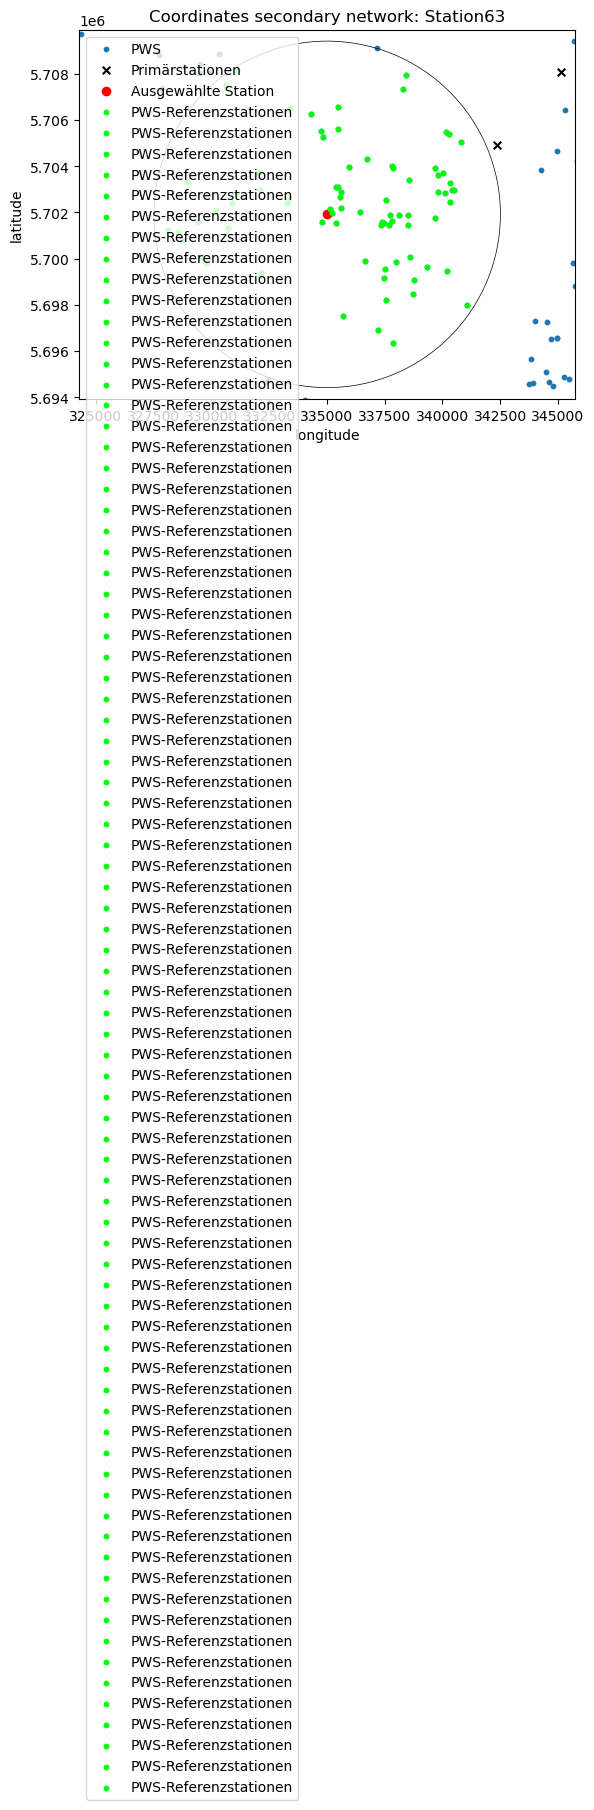

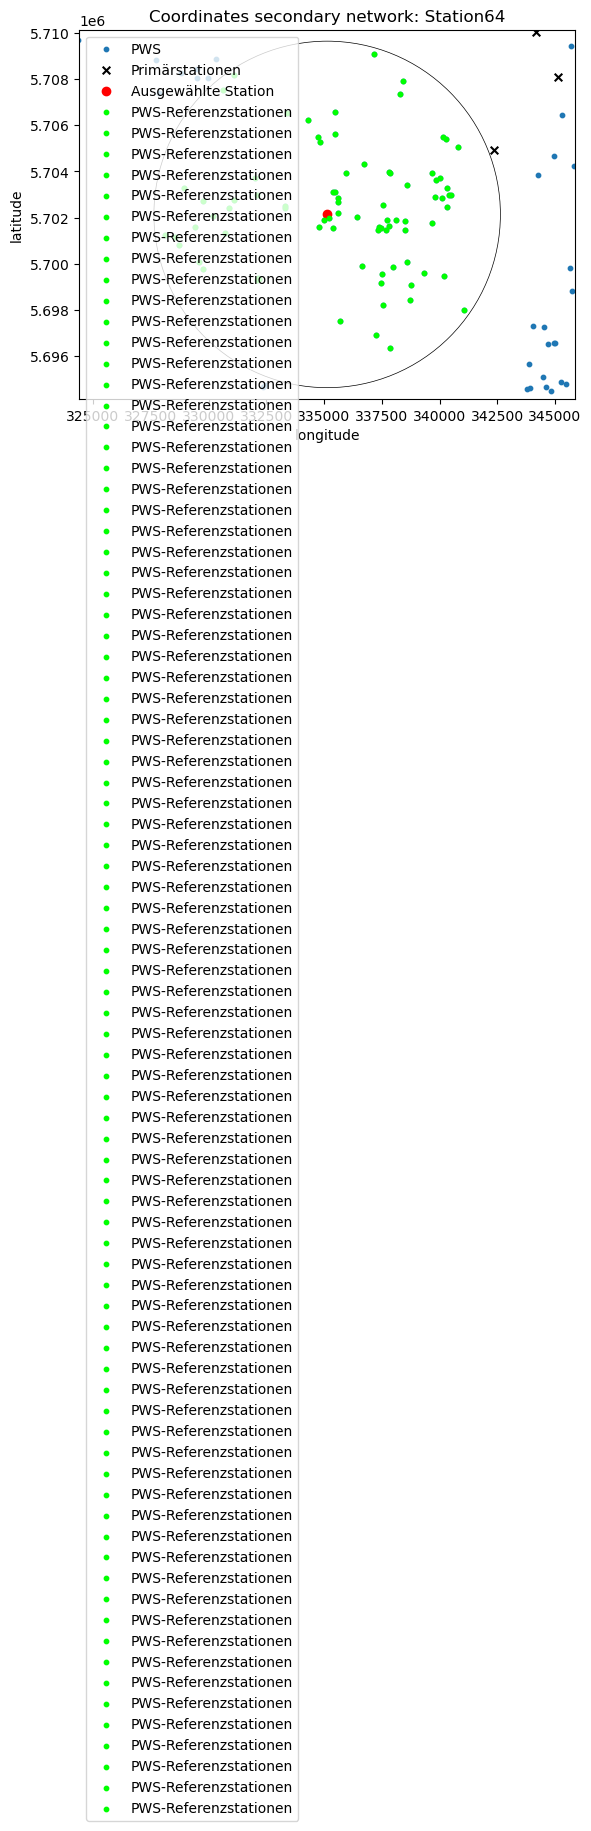

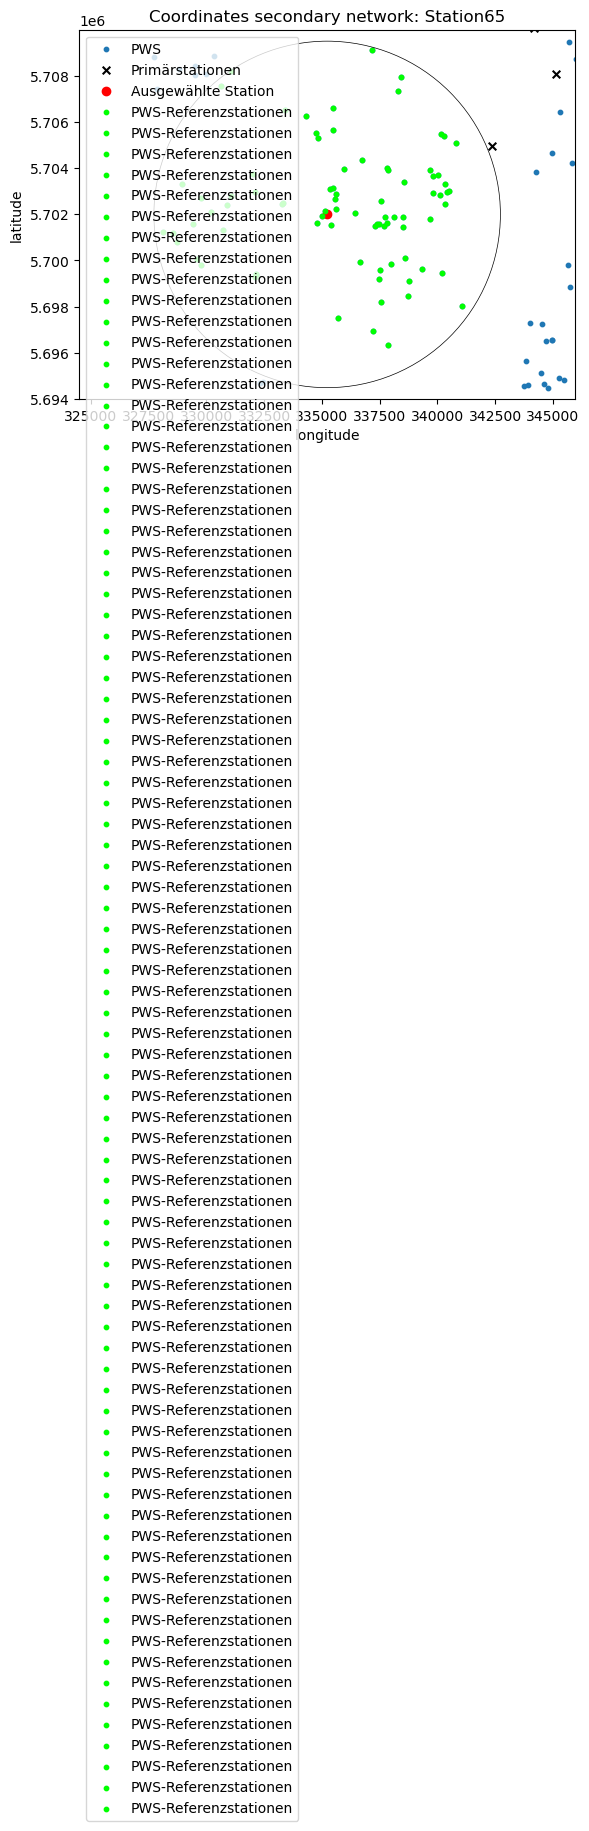

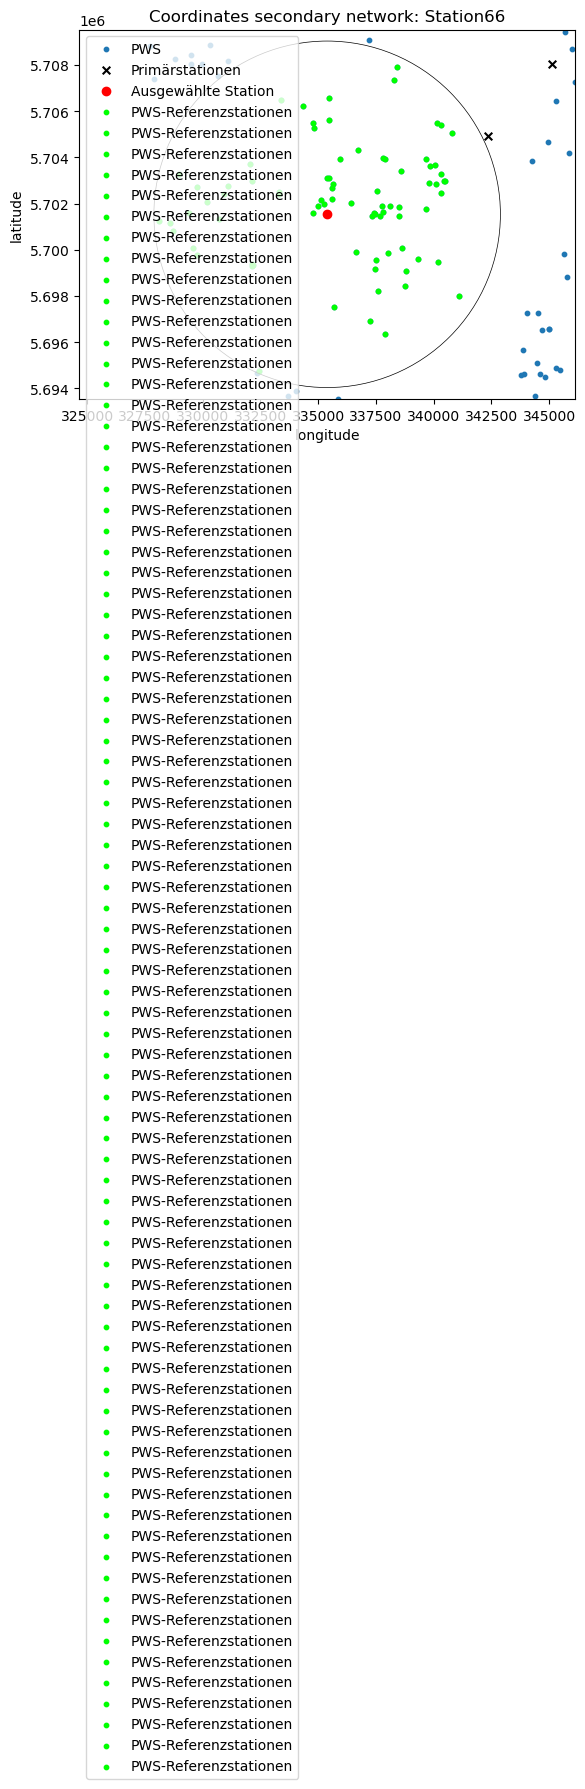

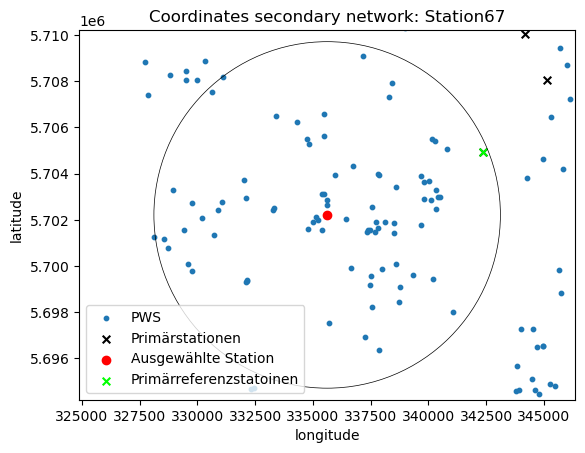

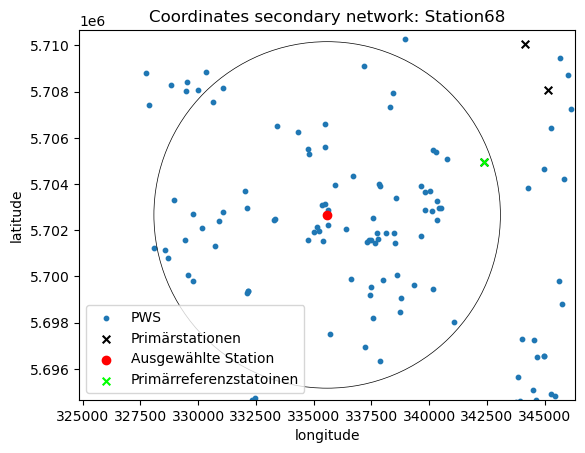

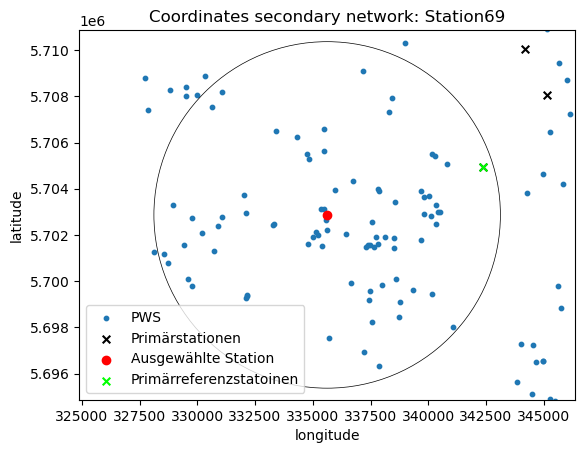

In [111]:
for i in range(63, 70):
    find_all_stations_in_range(coordinates_primary_utm32, coordinates_secondary_utm32, i, 8000, 7500, plot=True)